# Data Science at Scale Capstone Projct Final Report

### Linghao Zhang <zlhdnc1994@gmail.com>

This report can also be found [here](https://github.com/dnc1994/BlightFight/blob/master/src/Final-Report.ipynb). All my codes can be found [here](https://github.com/dnc1994/BlightFight) on GitHub. 

**Note: Since I already documented my solution [here](https://github.com/dnc1994/BlightFight/blob/master/README.md), I'll just go through my approaches and findings in this report. Yet you can find every detail in my iPython notebooks. They are self-explanatory and easily reproducible.**

## Let's go!

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
from IPython.display import Image

### Task

Work with real data collected in Detroit to help urban planners predict **blight (the deterioration and decay of buildings and older areas of large cities, due to neglect, crime, or lack of economic support)**.

### Preprocessing

Here's how I established the list of buildings:

1. Filter NAs and invalid coordinates.
2. Extract latitutude/longitude pair and address (in raw text) from 4 files.
3. Concatenate them into one single data frame.
4. Clean up the address field **(extract numbers, drop symbols, normalize spelling, expand abbreviations, etc).**
5. Cluster geolocations by fuzzy matching **(edit distance)** on address field and incident proximities (`eps = 0.000075`).
6. Represent each building with a rectangle centered at average coordinates.

I did try to cluster them by coordinates using [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN). The problem is that it cannot distinguish between a large building and two buildings very close to each other. I tried to combine both address similarity and geo-proximity but went into problems with implementaion. With precomputed distances, DBSCAN runs in O(n) time, but a distance matrix that huge can't fit in my memory; With on-the-fly distances, there's just no way to specifiy custom distance metric without diving into details of sklearn's implementation. Either way, it's very time-consuming to do it. Therefore I decided to only use geo-proximities as a heuristic (incidents that are too far away would not be assigned to the same building).

After that I simply assign positive labels for buildings associated with at least one demolition permits and randomly sampled the same amount of records from the remaining data as the negative class. This is what I used later for training. As for the rest of the data, I marked them **"out-of-sample buildings"** and used them in the final visualization.

### Features

I mainly used counts of three types of incidents (violations, calls and crimes). I also tried to include the properties of specific types of incidents. But a feature importance plot obtained by fitting a simple random forest model on the features gave me this:

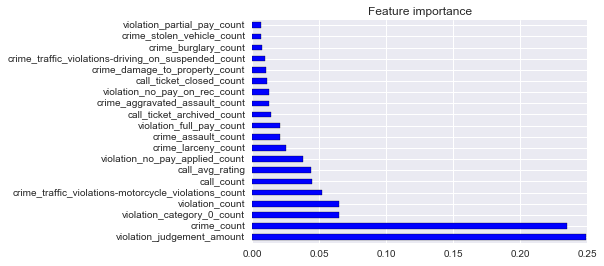

In [5]:
Image('./feat_imp.png')

You can see that counts of these 3 types of incidents are the most important. Because other "sub-counts" are in linear relation to them and have much less importance, it's logical to try eliminating them to simplify the model.

### Model

1. Before training, I split the data with a 7:3 ratio. The 30% of the data is reserved as hold-out validation set.
2. First I trained a **Gradient Boosted Trees** model using [Xgboost](https://github.com/dmlc/xgboost) with a **AUC** score of **0.85707** **on the hold-out validation set**.
3. Then I tried using only features `violation_judgement_amount, violation_count, crime_count, call_count, call_avg_rating` and limiting the maximum depth of trees to 4. It turns out that **this simplified model only loses less than 0.005 in terms of AUC scores, but greatly improves its interpretability**.

Here's the ROC curve of my final model:

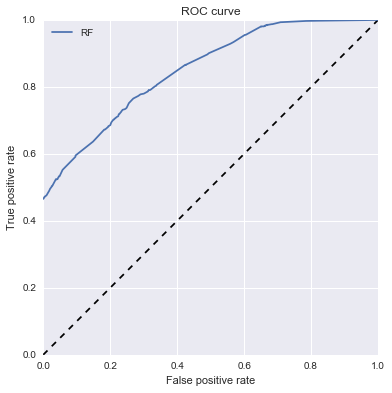

In [8]:
Image('./ROC_curve.png')

Here's a plot of the tree model trained:

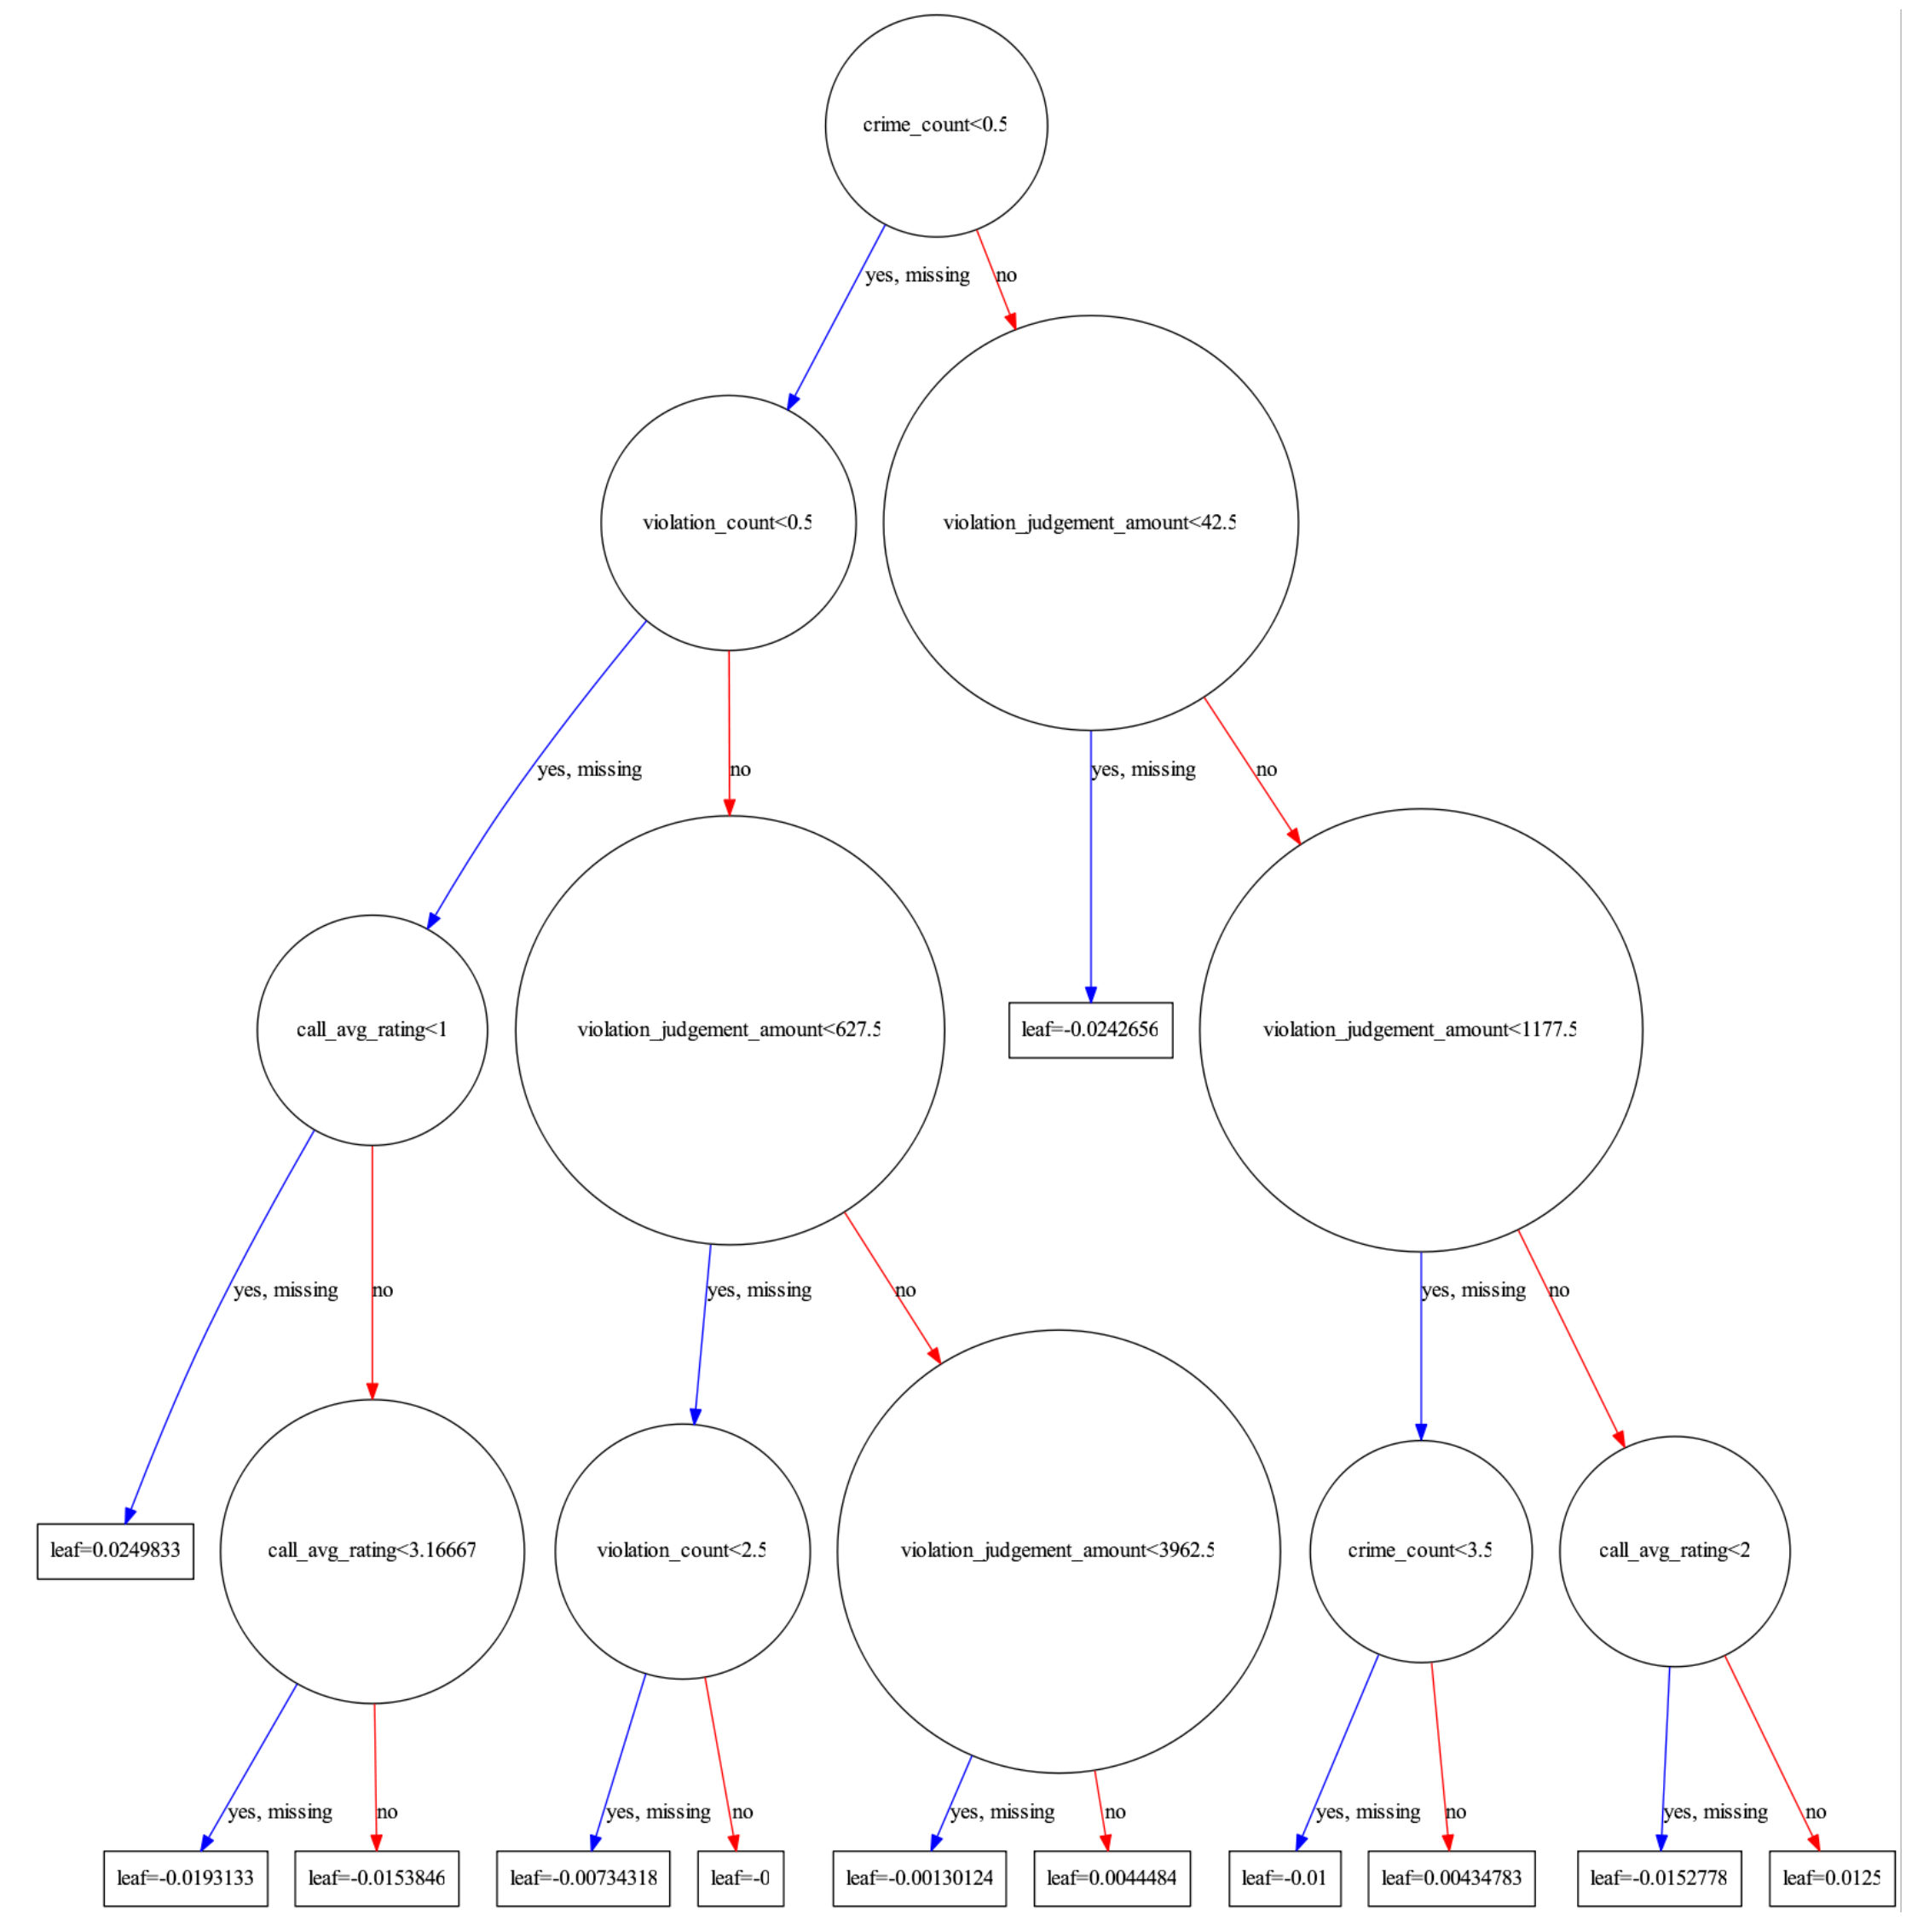

In [10]:
Image('./tree_plot.png')

### Visualization

I splitted the Detroit region into small grids and computed average risk for each grid. Here is a **Choropleth** map made using [folium](https://github.com/python-visualization/folium):

### Discussion

If I had more time, I could've:

- Utilize time features. Some buildings that are not very likely to be blighted now might become blighted in a few years. If there's a pattern related to time, we can do much more to improve the situation.
- Define some decaying spatial impact for incidents like crimes

## Thanks for reading!